# Description:

Clustering of latent space representation of trajectory data performed with DBSCAN.Clusters (not -1, noise) are fed into an autoencoder trained on the same data in the same way but in a separate trial. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import glob
import os
import seaborn as sns
import tensorflow as tf
import scipy
import glob
import sklearn 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import layers, models, optimizers
from tensorflow.keras.layers import Input, Activation, Dense, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam, SGD
from keras_tuner import BayesianOptimization, HyperParameters

2024-01-29 17:02:26.621869: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 17:02:26.621913: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 17:02:26.621942: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-29 17:02:26.629743: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-29 17:02:27.902698: W tensorflow/compiler/tf2t

# File Retrieval

In [2]:
# Data for the first round of clustering
folder_name_1 = 'AET_CF_Trial_14'
file_name_1 = '14_LSP_AET_CF_Predictions37'

# Location to save and load data for round 2 of clustering
folder_name_2 = 'AET_CF_All_Cluster_Trial_4_ES37'
if not os.path.exists(folder_name_2):
    os.makedirs(folder_name_2)
file_name_2 = '4_LSP_AET_CF_Clusters_'

# Location of differently trained AE's for round 2 of clustering
folder_name_3 = 'AET_CF_1_Cluster_Trial_1'
folder_name_4 = 'AET_CF_Trial_12'
folder_name_5 = 'AET_CF_Trial_13'

# Training History 

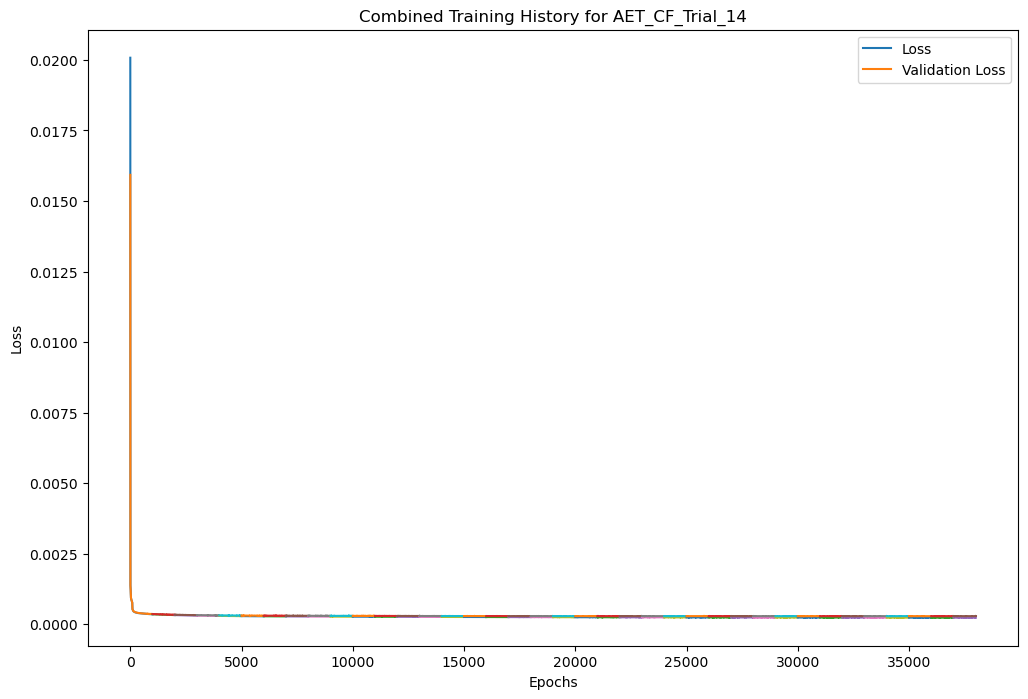

<Figure size 640x480 with 0 Axes>

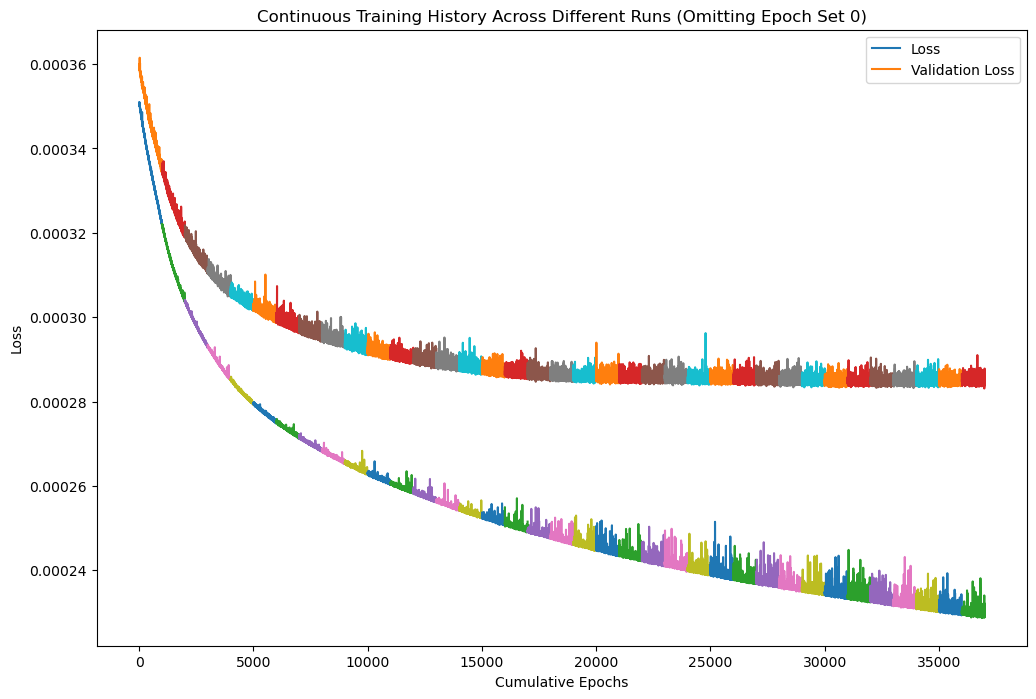

Minimum Loss: 0.0002 at Epoch 36890
Minimum Validation Loss: 0.0003 at Epoch 36984


<Figure size 640x480 with 0 Axes>

In [3]:
name = '14_LSP_AET_CF_' 

# Create a figure for plotting
plt.figure(figsize=(12, 8))

cumulative_epochs_1 = 0  # Variable to track the total number of epochs plotted

for count in range(38):  # 38 because limiting range to optimal validation loss epoch set
    file_name = os.path.join(folder_name_1, name + "Training_History" + str(count))
    try:
        # Load the training history file
        training_history = pd.read_pickle(file_name)
        
        # Number of epochs in the current training run
        num_epochs_1 = len(training_history)

        # Generate a range of epoch numbers for the current training run
        epoch_range_1 = range(cumulative_epochs_1, cumulative_epochs_1 + num_epochs_1)
        
        # Add labels only for the first epoch set
        if count == 0:
            loss_label = 'Loss'
            val_loss_label = 'Validation Loss'
        else:
            loss_label = None
            val_loss_label = None

        # Plot the training history with the adjusted epoch range
        plt.plot(epoch_range_1, training_history['loss'], label=loss_label)
        plt.plot(epoch_range_1, training_history['val_loss'], label=val_loss_label)

        # Update the cumulative number of epochs
        cumulative_epochs_1 += num_epochs_1

    except FileNotFoundError:
        print(f"File not found: {file_name}")

# Add labels
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Combined Training History for {folder_name_1}')

plt.show()

# Save the combined plot
plt.savefig(os.path.join(folder_name_1, 'Combined_Training_History.png'), dpi=300)
plt.clf()  

# Figure 2: No Epoch Set 0

# Create a figure for plotting
plt.figure(figsize=(12, 8))

# Initialize variables to track the minimum loss and validation loss
min_loss = float('inf')
min_val_loss = float('inf')
min_loss_epoch = None
min_val_loss_epoch = None
cumulative_epochs_2 = 0

for count in range(1, 38):  # Starting from 1 to omit epoch set 0
    file_name = os.path.join(folder_name_1, name + "Training_History" + str(count))
    try:
        # Load the training history file
        training_history = pd.read_pickle(file_name)
        
        # Number of epochs in the current training run
        num_epochs_2 = len(training_history)

        # Generate a range of epoch numbers for the current training run
        epoch_range_2 = range(cumulative_epochs_2, cumulative_epochs_2 + num_epochs_2)

        # Plot the training history
        plt.plot(epoch_range_2, training_history['loss'], label='Loss' if count == 1 else None)
        plt.plot(epoch_range_2, training_history['val_loss'], label='Validation Loss' if count == 1 else None)

        # Check and update minimum loss and validation loss
        local_min_loss = training_history['loss'].min()
        local_min_val_loss = training_history['val_loss'].min()
        local_min_loss_epoch = training_history['loss'].idxmin()
        local_min_val_loss_epoch = training_history['val_loss'].idxmin()

        if local_min_loss < min_loss:
            min_loss = local_min_loss
            min_loss_epoch = local_min_loss_epoch + cumulative_epochs_2
        if local_min_val_loss < min_val_loss:
            min_val_loss = local_min_val_loss
            min_val_loss_epoch = local_min_val_loss_epoch + cumulative_epochs_2

        # Update the cumulative number of epochs
        cumulative_epochs_2 += num_epochs_2

    except FileNotFoundError:
        print(f"File not found: {file_name}")

# Add legend and labels
plt.legend()
plt.xlabel('Cumulative Epochs')
plt.ylabel('Loss')
plt.title('Continuous Training History Across Different Runs (Omitting Epoch Set 0)')

# Display the figure
plt.show()

# Optionally save the figure
plt.savefig(os.path.join(folder_name_1, 'Continuous_Training_History_No_ES_0.png'), dpi=300)
plt.clf()  

# Print the minimum loss and validation loss with corresponding epochs
print(f"Minimum Loss: {min_loss:.4f} at Epoch {min_loss_epoch}")
print(f"Minimum Validation Loss: {min_val_loss:.4f} at Epoch {min_val_loss_epoch}")

# Clustering

In [4]:
# read in and plot the original data set
latent = pd.read_pickle(f'{folder_name_1}/{file_name_1}')
latent = latent.replace({'trajectory-0.0': '0', 'trajectory-1.0': '1'}).infer_objects()

In [5]:
# Set the 'index' column as the new index
latent.set_index('index', inplace=True)

# Remove the name of the new index
latent.index.name = None

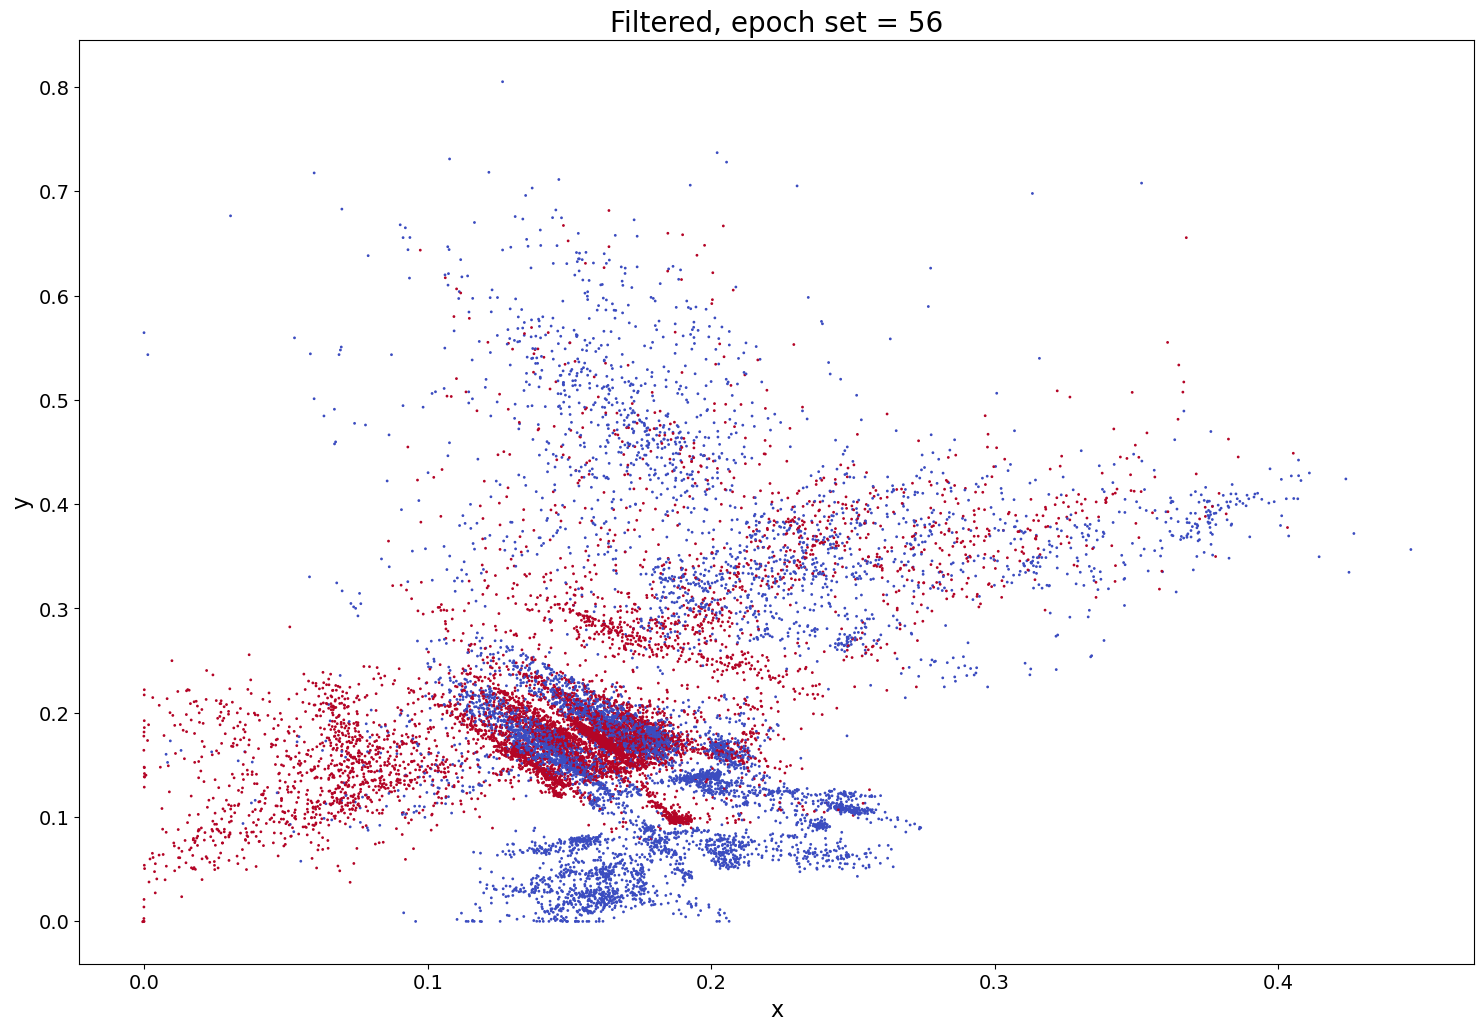

In [6]:
latent['z'] = pd.to_numeric(latent['z'], errors='coerce')

plt.figure(figsize=(18,12))
plt.scatter (latent.x,latent.y, c=latent.z, cmap="coolwarm", s = 1, alpha=1)
plt.title('Filtered, epoch set = 56', fontsize = 20)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize=14)
# plt.savefig("56_data.png", dpi = 300)

plt.show()

In [8]:
# remove the trajectory identity column for further processing
latent_n = latent.drop(['z'], axis = 1)

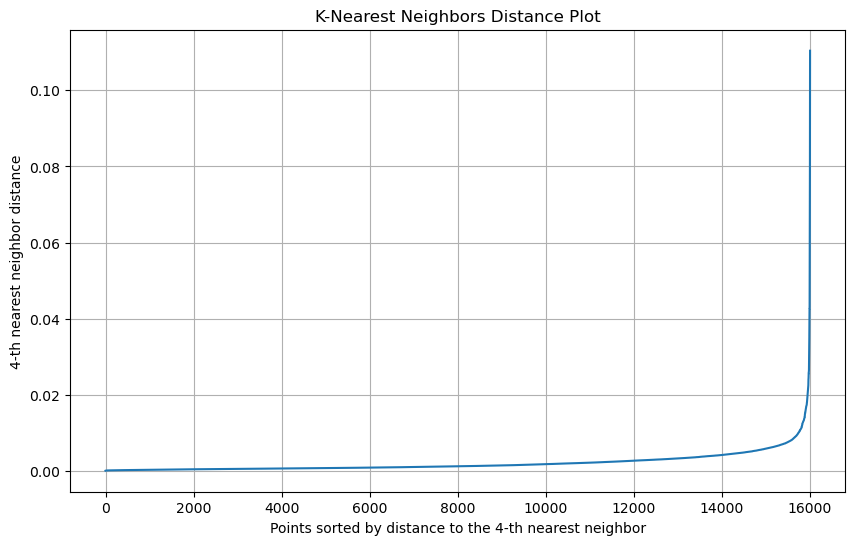

In [9]:
def plot_knn_distances(latent_n, k=4):
    """
    Plot the k-nearest neighbors distance for each point in the dataset to help
    determine a good 'eps' value for DBSCAN.

    Parameters:
    - data: The dataset (as a numpy array or similar).
    - k: The number of neighbors to consider (typically the same as 'min_samples' in DBSCAN).
    """
    # Compute the nearest neighbors
    nn = NearestNeighbors(n_neighbors=k).fit(latent_n)
    distances, _ = nn.kneighbors(latent_n)

    # Sort and plot the distances
    sorted_distances = np.sort(distances[:, k-1], axis=0)
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_distances)
    plt.xlabel('Points sorted by distance to the {}-th nearest neighbor'.format(k))
    plt.ylabel('{}-th nearest neighbor distance'.format(k))
    plt.title('K-Nearest Neighbors Distance Plot')
    plt.grid(True)
    plt.show()

# Then call the function with your data
# plot_knn_distances(df55.values, k=4) 


plot_knn_distances(latent_n.values, k=4)  # Adjust 'k' as needed

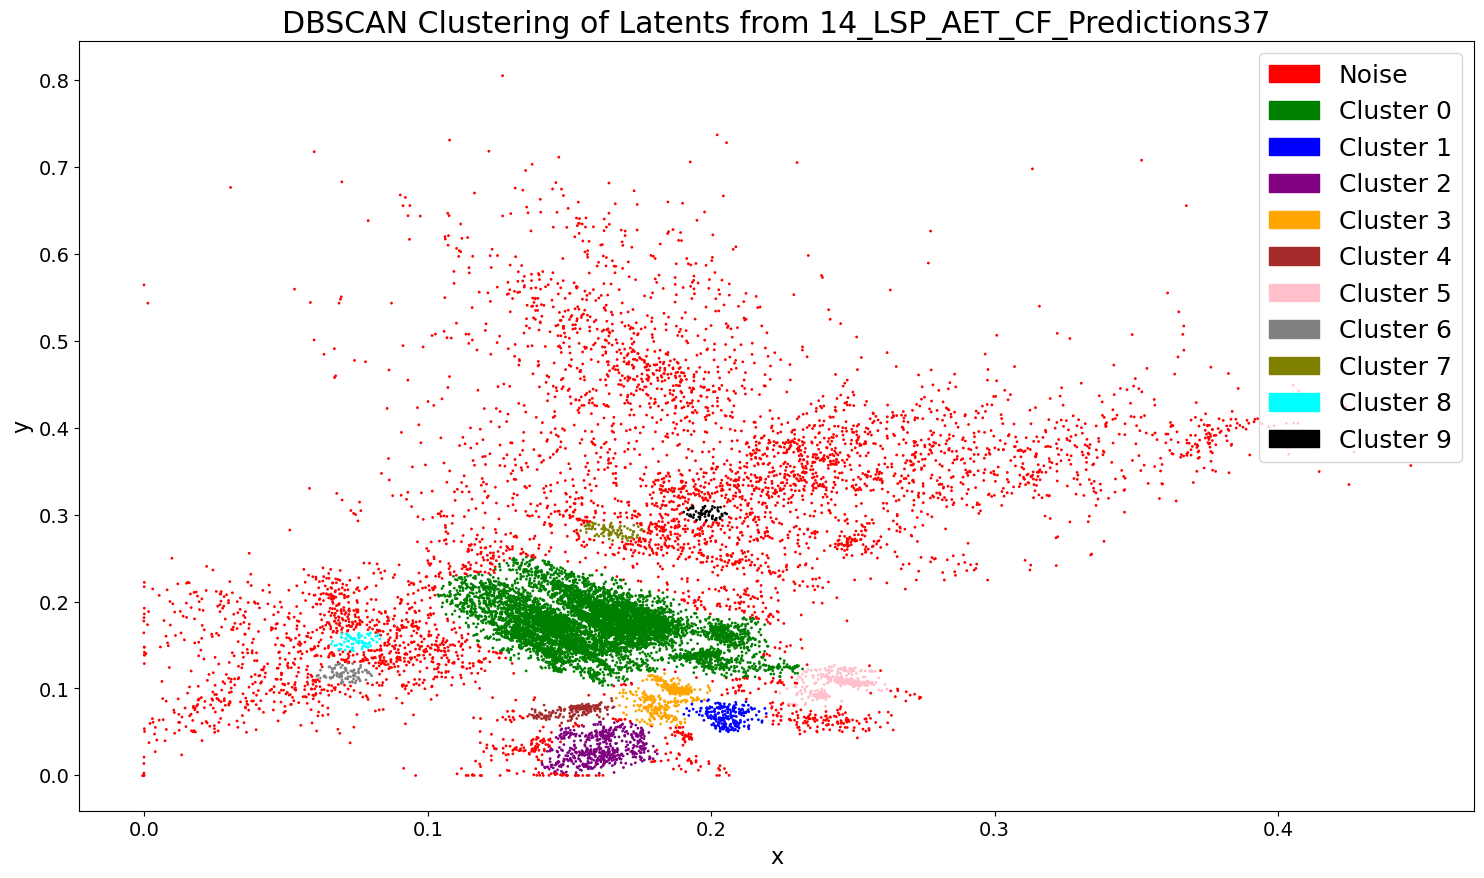

Number of clusters: 10


In [10]:
y_pred = DBSCAN(eps=0.008, min_samples=50).fit_predict(latent_n)

plt.rcParams['font.size'] = '18'
plt.figure(figsize=(18,10))

# Define a custom color palette
colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan', 'black', 'yellow', 'magenta', 'maroon', 'navy']

# Creating a mapping for cluster labels to colors
unique_labels = np.unique(y_pred)
label_color_map = {lbl: colors[i] for i, lbl in enumerate(unique_labels)}

# Map y_pred to the defined colors
cluster_colors = [label_color_map[label] for label in y_pred]

# Scatter plot using the custom colors
plt.scatter(latent_n.iloc[:,0], latent_n.iloc[:,1], c=cluster_colors, s=1)

# Creating a legend
legend_handles = [mpatches.Patch(color=label_color_map[lbl], label=f'Cluster {lbl}' if lbl != -1 else 'Noise') for lbl in unique_labels]

plt.legend(handles=legend_handles, loc='upper right')

# Setting labels, titles, and ticks
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'DBSCAN Clustering of Latents from {file_name_1}')
png_path = os.path.join(folder_name_2, f'{file_name_1}_Original_Cluster_All.png')
plt.savefig(png_path, dpi=300)
plt.show()

# Print the number of clusters
print('Number of clusters: {}'.format(len(unique_labels[unique_labels != -1])))

In [11]:
# latent_n is DataFrame after removing the 'z' column
# latent is the original DataFrame with the 'z' column

# Add the cluster labels to your DataFrame
latent_n['cluster'] = y_pred
latent['cluster'] = y_pred

# Reattach the 'z' column
latent_n['z'] = latent['z']

# Group by cluster and trajectory identity, then count the occurrences
cluster_trajectory_count = latent_n.groupby(['cluster', 'z']).size().reset_index(name='count')

print(cluster_trajectory_count)

    cluster  z  count
0        -1  0   2621
1        -1  1   2397
2         0  0   3855
3         0  1   5101
4         1  0    214
5         2  0    547
6         3  0    207
7         3  1    233
8         4  0    179
9         4  1      2
10        5  0    327
11        5  1     10
12        6  0      7
13        6  1     81
14        7  0      6
15        7  1     80
16        8  0      5
17        8  1     71
18        9  0     32
19        9  1     25


/home/chaseflynn/anaconda3/envs/2one/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/chaseflynn/anaconda3/envs/2one/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


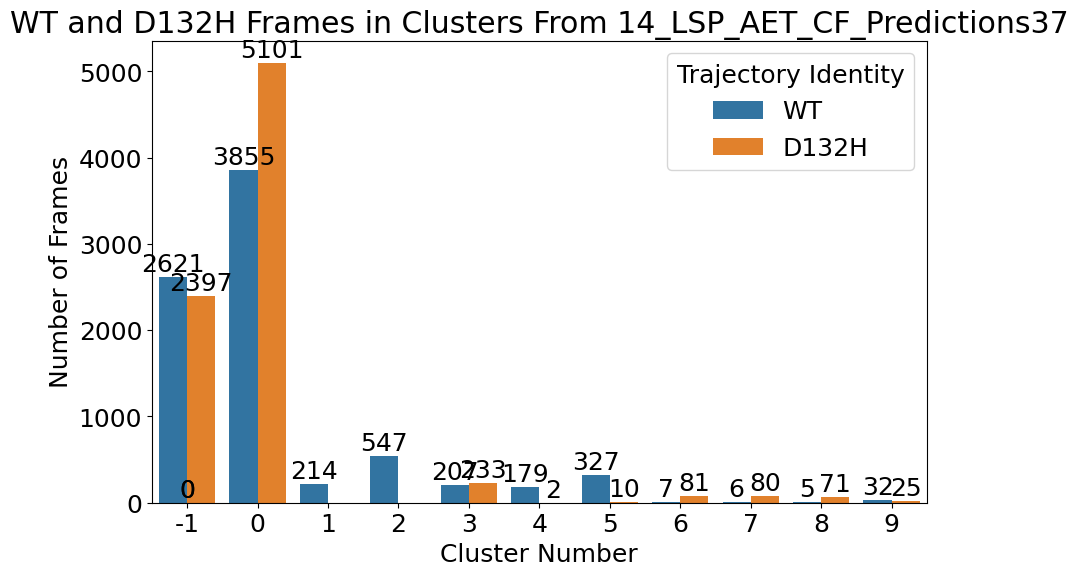

In [12]:
# 0 is WT and 1 is D132H
cluster_trajectory_count['z'] = cluster_trajectory_count['z'].replace({0: 'WT', 1: 'D132H'})

# Create the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='cluster', y='count', hue='z', data=cluster_trajectory_count)

# Setting labels and title
plt.xlabel('Cluster Number')
plt.ylabel('Number of Frames')
plt.title(f'WT and D132H Frames in Clusters From {file_name_1}')
plt.xticks(rotation=0)
plt.legend(title='Trajectory Identity')

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

# Show the plot
plt.show()

# Cluster Indices

In [13]:
# Create a dictionary to hold the indices for each cluster
cluster_indices = {}

# Loop through each unique cluster label
for cluster_label in np.unique(y_pred):
    # Extract indices of the datapoints belonging to the current cluster
    indices = latent_n[latent_n['cluster'] == cluster_label].index.tolist()
    # Store these indices in the dictionary
    cluster_indices[cluster_label] = indices

# Print the summary of indices for each cluster
for cluster_label, indices in cluster_indices.items():
    print(f"Cluster {cluster_label}: {len(indices)} datapoints")
    print(f"Indices: {indices}\n")

Cluster -1: 5018 datapoints
Indices: [33093, 49128, 48098, 35170, 59331, 3367, 70901, 38551, 13677, 70114, 44468, 32641, 71178, 46247, 10210, 10317, 59871, 16699, 72359, 35229, 33394, 50496, 36002, 26323, 36794, 74859, 33094, 35908, 30119, 10280, 44365, 40269, 10137, 19113, 30553, 32925, 36836, 33169, 47479, 46562, 70869, 33736, 32018, 74734, 75826, 31709, 46850, 47948, 46177, 45684, 33821, 26590, 72721, 37061, 32114, 14999, 15089, 74322, 36691, 39088, 75866, 49051, 34330, 71902, 46991, 34606, 30640, 32274, 26554, 48406, 37620, 35499, 49351, 32397, 37085, 31387, 32166, 38037, 20587, 34022, 71054, 70503, 20006, 60206, 46855, 20536, 36519, 73180, 16632, 48259, 37586, 40010, 46406, 70308, 30745, 44031, 10022, 40370, 48320, 40063, 34676, 32035, 33272, 16121, 50185, 4820, 33129, 38152, 45628, 15093, 46371, 46274, 32658, 46123, 10192, 45698, 34617, 76315, 35632, 34457, 32973, 31950, 48158, 47514, 34352, 60138, 32068, 32721, 35260, 31115, 36008, 41051, 45365, 50182, 37118, 73025, 37134, 49143

# Clustering Round 2

In [14]:
# Reminder:
print('folder_name_1')
print(folder_name_1)

print('file_name_1')
print(file_name_1)

print('folder_name_2')
print(folder_name_2)

print('file_name_2')
print(file_name_2)

print('folder_name_3')
print(folder_name_3)

# print('file_name_3')
# print(file_name_3)

folder_name_1
AET_CF_Trial_14
file_name_1
14_LSP_AET_CF_Predictions37
folder_name_2
AET_CF_All_Cluster_Trial_4_ES37
file_name_2
4_LSP_AET_CF_Clusters_
folder_name_3
AET_CF_1_Cluster_Trial_1


In [15]:
# Drop the first 2 columns
latent.drop(['x', 'y'], axis=1, inplace=True)

In [16]:
# Load original data
y_valid_f = pd.read_csv(f'{folder_name_1}/y_valid_f.csv', index_col=0)
X_valid_f = pd.read_csv(f'{folder_name_1}/X_valid_f.csv', index_col=0)
X_train_f = pd.read_csv(f'{folder_name_1}/X_train_f.csv', index_col=0)

In [17]:
# Saving the original distance data for frames corresponding to each cluster
unique_clusters = latent_n['cluster'].unique()

for cluster_number in unique_clusters:
    # Select indices of the current cluster
    selected_cluster_indices = latent_n[latent_n['cluster'] == cluster_number].index

    # Filter the data for the current cluster
    filtered_data = X_valid_f.loc[selected_cluster_indices]

    # Save the filtered data for the current cluster
    filtered_data.to_csv(f'{folder_name_2}/Recluster_Latent_{cluster_number}.csv')

    # Save indices of the filtered data for the current cluster
    latent[latent['cluster'] == cluster_number].to_csv(f'{folder_name_2}/Recluster_Index_{cluster_number}.csv')

# Latent Space of Clusters

In [18]:
# Loading autoencoder model from second round of training
model_path = f'{folder_name_3}/models/saved_model_1_LSP_AET_CF_37'
autoencoder = tf.keras.models.load_model(model_path)

dr_model = tf.keras.models.Model(inputs=autoencoder.get_layer('ae_input').input,
                                 outputs=autoencoder.get_layer('ae_latent').output)

2024-01-29 17:06:35.844226: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [21]:
# Custom color palette to match first fig
color_palette = {
    -1: 'red', 0: 'green', 1: 'blue', 2: 'purple', 3: 'orange', 
    4: 'brown', 5: 'pink', 6: 'gray', 7: 'olive', 8: 'cyan', 
    9: 'black', 10: 'yellow', 11: 'magenta'
}

clusters = [1, 2, 3, 4, 5, 6, 7, 8, 9]  # Replace with desired clusters

# String clusters for file names and title
clusters_str = '_'.join(map(str, clusters))
clusters_title = ', '.join(map(str, clusters))

# Initialize an empty DataFrame for selected clusters
select_clusters_df = pd.DataFrame()

for cluster in clusters:
    # Load the data for the current cluster
    latent_file = f'{folder_name_2}/Recluster_Latent_{cluster}.csv'
    ID_file = f'{folder_name_2}/Recluster_Index_{cluster}.csv'

    latent_data = pd.read_csv(latent_file, index_col=0)
    ID_data = pd.read_csv(ID_file, index_col=0)

    # Convert the data to numpy array if necessary
    X_batch = latent_data.values

    # Generate latent space representations
    latent_representations = dr_model.predict(X_batch)

    # Create DataFrame for current cluster and append to select_clusters_df
    df = pd.DataFrame(latent_representations, index=latent_data.index, columns=['x', 'y'])
    df['z'] = ID_data['z']
    df['cluster'] = ID_data['cluster']
    
    select_clusters_df = select_clusters_df._append(df)

# Map selected clusters to their respective colors
selected_colors = {cluster: color_palette[cluster] for cluster in clusters}

# Visualization and saving single .png file for all clusters
# R1LG: Origin of data from round 1 of latent space generation and clustering
# R2LG: Origin of differently trained AE model for second round of latent space generation
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='cluster', data=select_clusters_df, s=10, palette=selected_colors)
plt.title(f'Latent Space Representation - Clusters: {clusters_title}')
plt.legend(title='Cluster')
png_path = os.path.join(folder_name_2, f'R1LG_{folder_name_2}_R2LG_{folder_name_3}_Clusters_{clusters_str}.png')
plt.savefig(png_path, dpi=300)
plt.close()

# Saving the combined data in pickle format
pickle_path = os.path.join(folder_name_2, f'R1LG_{folder_name_2}_R2LG_{folder_name_3}_Clusters_{clusters_str}')
select_clusters_df.to_pickle(pickle_path)

print("Combined processing and saving completed for all specified clusters.")

6/6 [==============================] - 0s 1ms/step
Combined processing and saving completed for all specified clusters.


# Joining Generated Figs With Original Cluster Figure:

In [22]:
def join_images(original_image_path, new_image_path, output_image_path):
    # Open the original and new images
    original_image = Image.open(original_image_path)
    new_image = Image.open(new_image_path)
    
    # Calculate the total height and the max width
    total_height = original_image.height + new_image.height
    max_width = max(original_image.width, new_image.width)

    # Create a new image with the appropriate size
    combined_image = Image.new('RGB', (max_width, total_height))

    # Paste the original and new images into the combined image
    combined_image.paste(original_image, (0, 0))
    combined_image.paste(new_image, (0, original_image.height))

    # Save the combined image
    combined_image.save(output_image_path)

# Define the path for the original PNG
AC_png_path = os.path.join(folder_name_2, f'{file_name_1}_Original_Cluster_All.png')

# Iterate through the files in the directory
for file in os.listdir(folder_name_2):
    if file.startswith("R1LG_") and file.endswith(".png"):
        # Construct the full file path
        NC_png_path = os.path.join(folder_name_2, file)
        
        # Extract clusters_str from the file name
        clusters_str = file.split('Clusters_')[-1].split('.png')[0]

        # Define the path for the new combined image
        New_png_path = os.path.join(folder_name_2, f'Combined_R1_{folder_name_2}_R2_{folder_name_3}_Clusters_{clusters_str}.png')

        # Join the original and new images
        join_images(AC_png_path, NC_png_path, New_png_path)

print("All images combined.")

All images combined.


# Clustering round 2

In [23]:
# Insert the clusters to be analyzed below separated by '_'
clusters_to_analyze = '0_1_2_3_4_5_6_7_8_9'
path_to_analysis_pickle = os.path.join(folder_name_2, f'R1LG_{folder_name_2}_R2LG_{folder_name_3}_Clusters_{clusters_to_analyze}')

In [24]:
# read in and plot the original data set
latent_2 = pd.read_pickle(path_to_analysis_pickle)

In [25]:
print(latent_2)

              x         y  z  cluster
51741  0.450107  0.304837  1        0
62945  0.466740  0.250948  1        0
24816  0.407211  0.367983  0        0
55220  0.451878  0.306098  1        0
2392   0.483308  0.312339  0        0
...         ...       ... ..      ...
31181  0.602203  0.219404  0        9
73032  0.620046  0.224886  1        9
73011  0.593359  0.220526  1        9
37138  0.631433  0.219883  0        9
73513  0.574183  0.192792  1        9

[10982 rows x 4 columns]


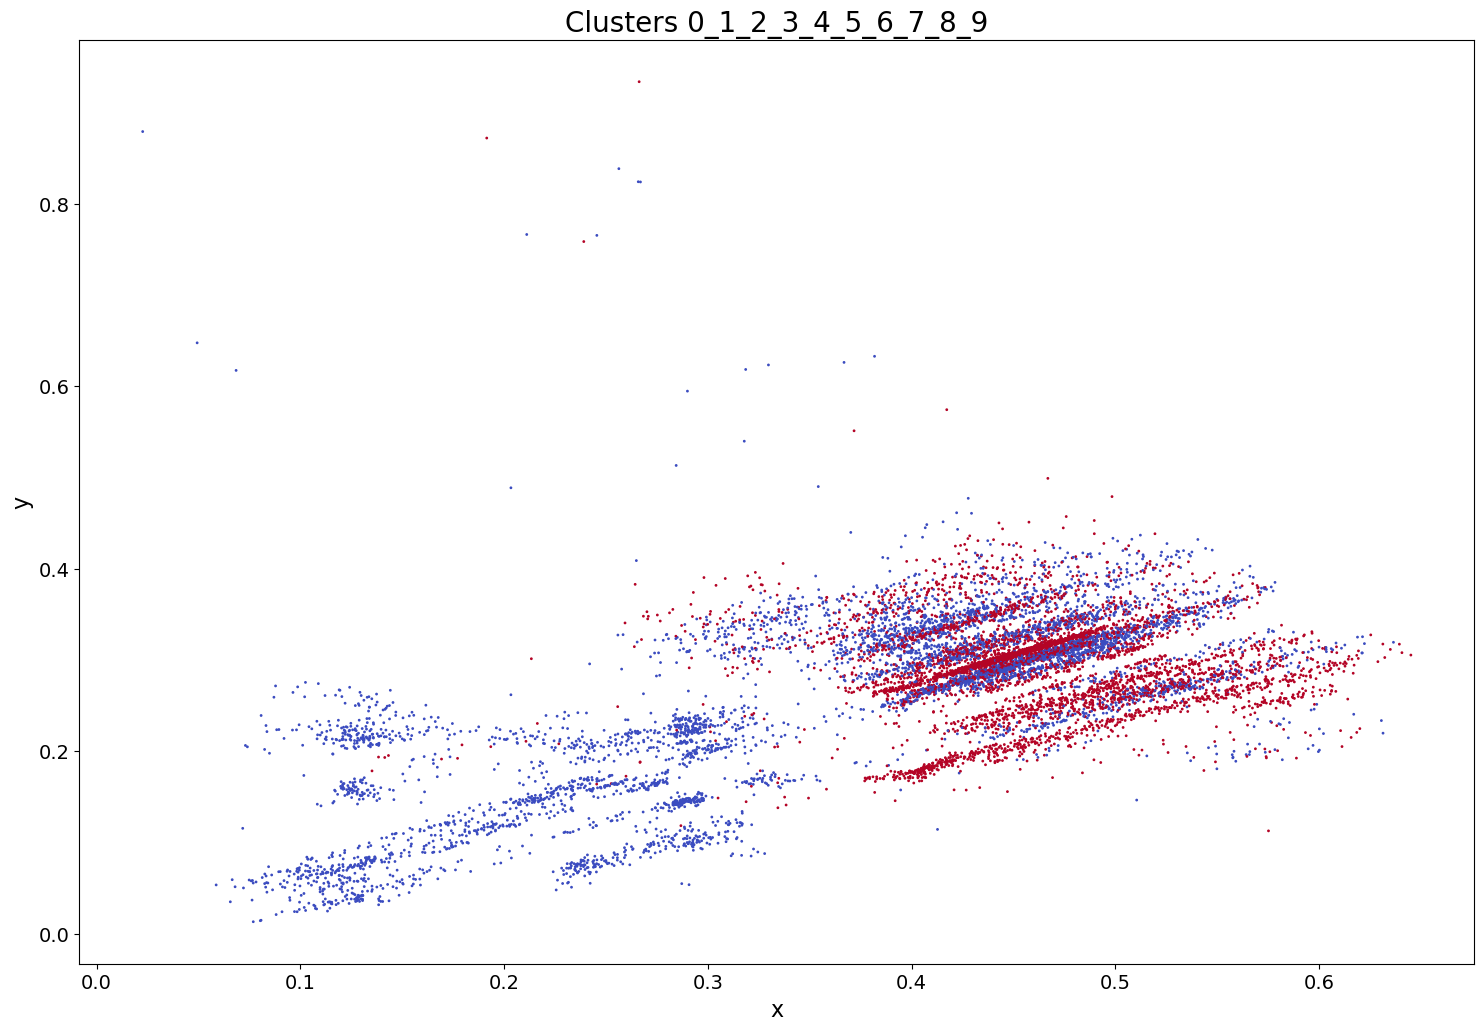

In [26]:
plt.figure(figsize=(18,12))
plt.scatter (latent_2.x,latent_2.y, c=latent_2.z, cmap="coolwarm", s = 1, alpha=1)
plt.title(f'Clusters {clusters_to_analyze}', fontsize = 20)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize=14)

plt.show()

In [27]:
# remove the trajectory identity column for further processing
latent_2n = latent_2.drop(['z', 'cluster'], axis = 1)
print(latent_2n)

              x         y
51741  0.450107  0.304837
62945  0.466740  0.250948
24816  0.407211  0.367983
55220  0.451878  0.306098
2392   0.483308  0.312339
...         ...       ...
31181  0.602203  0.219404
73032  0.620046  0.224886
73011  0.593359  0.220526
37138  0.631433  0.219883
73513  0.574183  0.192792

[10982 rows x 2 columns]


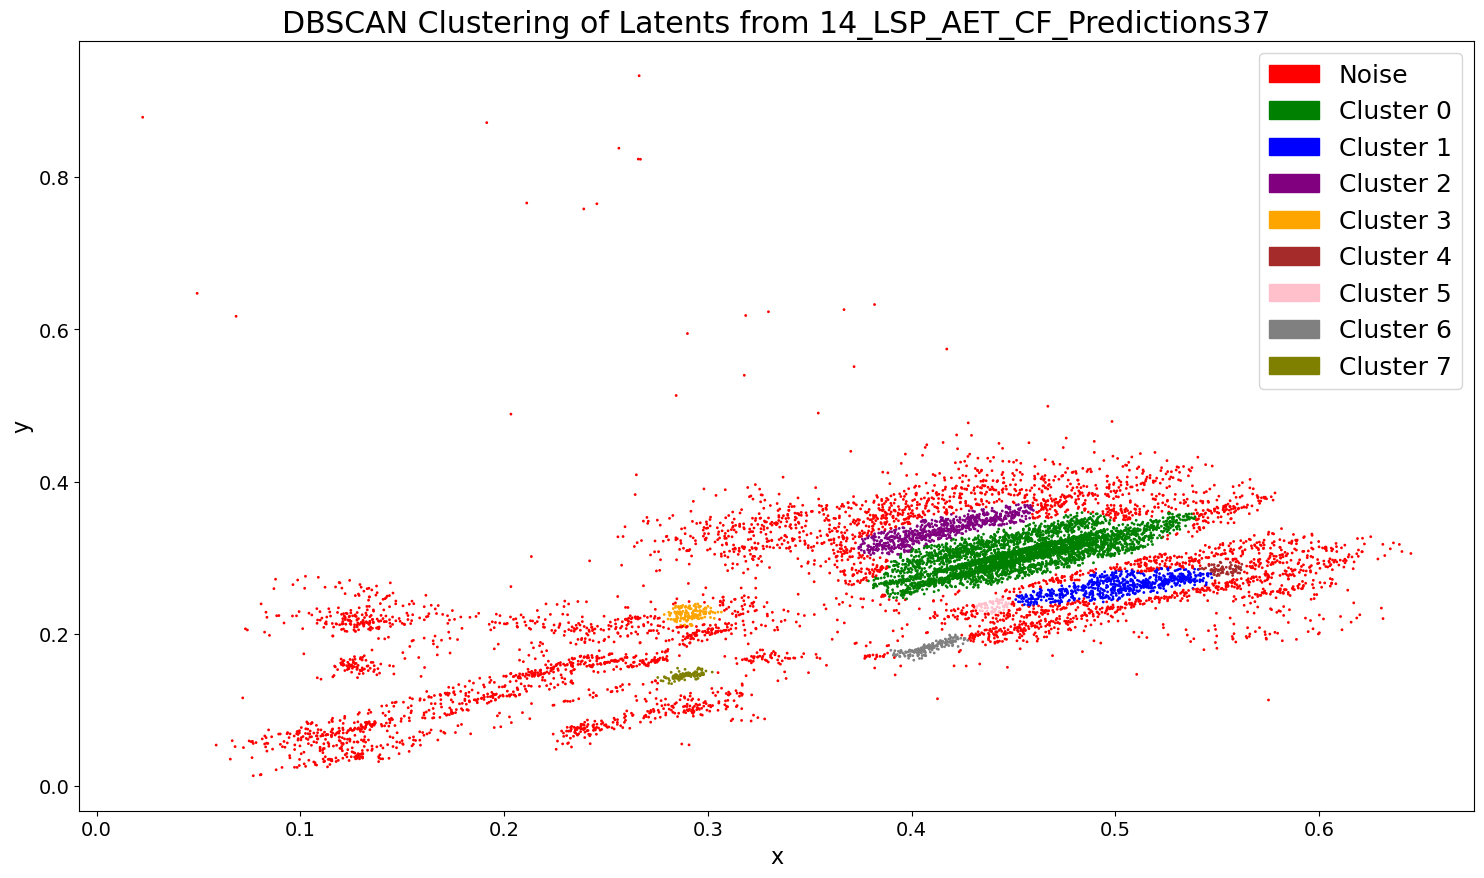

Number of clusters: 8


In [29]:
y_pred_2 = DBSCAN(eps=0.008, min_samples=50).fit_predict(latent_2n)

plt.rcParams['font.size'] = '18'
plt.figure(figsize=(18,10))

# Define a custom color palette
colors_2 = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan', 'black', 'yellow', 'magenta', 'maroon', 'navy']

# Creating a mapping for cluster labels to colors
unique_labels_2 = np.unique(y_pred_2)
label_color_map_2 = {lbl: colors_2[i] for i, lbl in enumerate(unique_labels_2)}

# Map y_pred to the defined colors
cluster_colors_2 = [label_color_map_2[label] for label in y_pred_2]

# Scatter plot using the custom colors
plt.scatter(latent_2n.iloc[:,0], latent_2n.iloc[:,1], c=cluster_colors_2, s=1)

# Creating a legend
legend_handles_2 = [mpatches.Patch(color=label_color_map_2[lbl], label=f'Cluster {lbl}' if lbl != -1 else 'Noise') for lbl in unique_labels_2]

plt.legend(handles=legend_handles_2, loc='upper right')

# Setting labels, titles, and ticks
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'DBSCAN Clustering of Latents from {file_name_1}')
png_path = os.path.join(folder_name_2, f'{file_name_1}_New_Cluster_All_No_-1.png')
plt.savefig(png_path, dpi=300)
plt.show()

# Print the number of clusters
print('Number of clusters: {}'.format(len(unique_labels_2[unique_labels_2 != -1])))

In [30]:
# Add the cluster labels to your DataFrame
latent_2n['new cluster'] = y_pred_2

# Reattach the 'z' column
latent_2n['z'] = latent_2['z']
latent_2n['old cluster'] = latent_2['cluster']

# Group by cluster and trajectory identity, then count the occurrences
cluster_trajectory_count = latent_2n.groupby(['new cluster', 'z']).size().reset_index(name='count')

print(cluster_trajectory_count)
print(latent_2n)

    new cluster  z  count
0            -1  0   2849
1            -1  1   1627
2             0  0   1647
3             0  1   2939
4             1  0    165
5             1  1    478
6             2  0    430
7             2  1    273
8             3  0    142
9             3  1      3
10            4  0     25
11            4  1     48
12            5  0      1
13            5  1     65
14            6  1    170
15            7  0    120
              x         y  new cluster  z  old cluster
51741  0.450107  0.304837            0  1            0
62945  0.466740  0.250948            1  1            0
24816  0.407211  0.367983           -1  0            0
55220  0.451878  0.306098            0  1            0
2392   0.483308  0.312339            0  0            0
...         ...       ...          ... ..          ...
31181  0.602203  0.219404           -1  0            9
73032  0.620046  0.224886           -1  1            9
73011  0.593359  0.220526           -1  1            9
37138  0

/home/chaseflynn/anaconda3/envs/2one/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/chaseflynn/anaconda3/envs/2one/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


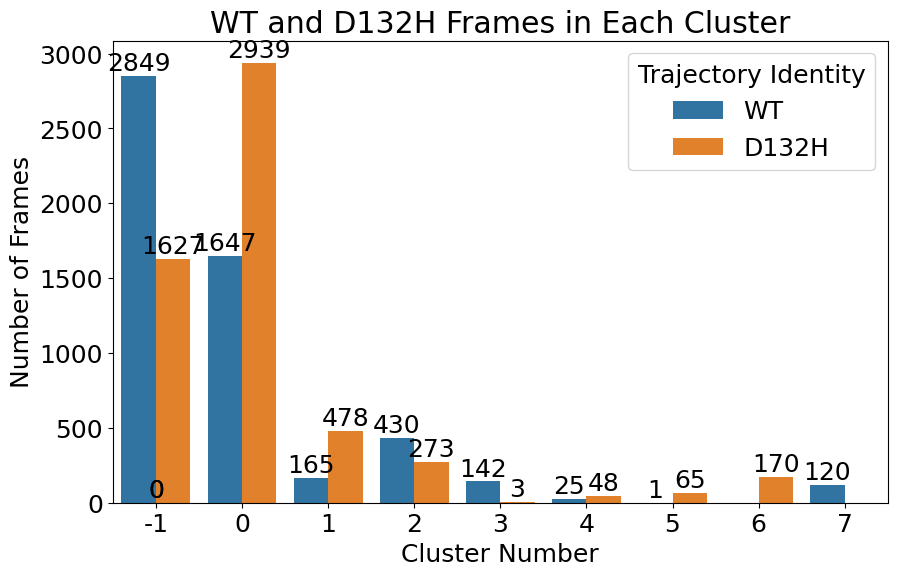

In [31]:
# 0 is WT and 1 is D132H
cluster_trajectory_count['z'] = cluster_trajectory_count['z'].replace({0: 'WT', 1: 'D132H'})

# Create the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='new cluster', y='count', hue='z', data=cluster_trajectory_count)

# Setting labels and title
plt.xlabel('Cluster Number')
plt.ylabel('Number of Frames')
plt.title('WT and D132H Frames in Each Cluster')
plt.xticks(rotation=0)
plt.legend(title='Trajectory Identity')

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

# Show the plot
plt.show()

In [32]:
# 1. Create the contingency table
contingency_table = pd.crosstab(latent_2n['new cluster'], latent_2n['old cluster'])

# 2. Iterative Matching
best_matches = {}
remaining_old_clusters = list(contingency_table.columns)

for new_cluster in contingency_table.index:
    best_old_cluster = contingency_table.loc[new_cluster, remaining_old_clusters].idxmax()
    best_matches[new_cluster] = best_old_cluster
    remaining_old_clusters.remove(best_old_cluster)

# 3. Calculate matching percentage for each new cluster
matching_percentages = {new_cluster: (contingency_table.loc[new_cluster, best_matches[new_cluster]] / contingency_table.loc[new_cluster].sum()) * 100 for new_cluster in best_matches}

# 4. Calculate overall matching percentage
overall_matching = sum(contingency_table.loc[new_cluster, best_matches[new_cluster]] for new_cluster in best_matches) / contingency_table.sum().sum() * 100

# Print the results
print("Best match for each new cluster:\n", best_matches)
print("\nMatching percentages for each new cluster:\n", matching_percentages)
print("\nOverall matching percentage:", overall_matching)


Best match for each new cluster:
 {-1: 0, 0: 8, 1: 7, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}

Matching percentages for each new cluster:
 {-1: 63.44950848972297, 0: 1.0902747492368077, 1: 0.15552099533437014, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0}

Overall matching percentage: 26.324895283190674


In [33]:
# Filter the DataFrame for rows where 'new cluster' is 4
cluster_4_data = latent_2n[latent_2n['new cluster'] == 4]
cluster_3_data = latent_2n[latent_2n['new cluster'] == 3]

# Print the resulting DataFrame with cluster 3
print('cluster 3 data')
print(cluster_3_data)

# Print the resulting DataFrame with cluster 4
print('cluster 4 data')
print(cluster_4_data)

cluster 3 data
              x         y  new cluster  z  old cluster
29537  0.283027  0.233021            3  0            0
29299  0.295007  0.223896            3  0            0
29617  0.296227  0.224197            3  0            0
29579  0.298381  0.228945            3  0            0
4980   0.288100  0.210183            3  0            0
...         ...       ...          ... ..          ...
29592  0.295609  0.219649            3  0            0
29815  0.287193  0.234873            3  0            0
29632  0.295305  0.219848            3  0            0
29860  0.285095  0.228927            3  0            0
29603  0.295086  0.222910            3  0            0

[145 rows x 5 columns]
cluster 4 data
              x         y  new cluster  z  old cluster
62938  0.548497  0.290788            4  1            0
65060  0.550984  0.276653            4  1            0
25625  0.552561  0.282053            4  0            0
22705  0.548305  0.277999            4  0            0
65107  0.54